Notebook: 
https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition/notebook

https://www.kaggle.com/code/yusufkorayhasdemir/face-emotion-recognition


Dataset:
https://www.kaggle.com/datasets/yusufkorayhasdemir/fer2013csv

Pic files:
https://www.kaggle.com/datasets/msambare/fer2013

# Mount Drive and Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

# Read Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MPMD3.4 AI Balloons Happy Face/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Data Understanding

## Usage column

In [ ]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
df.groupby('Usage').size()

Usage
PrivateTest     3589
PublicTest      3589
Training       28709
dtype: int64

In [ ]:
#TrainTestPercentage = int((len(df[df['Usage'] == 'Training']) / len(df))*100)
#print(f'The training set percentage is {TrainTestPercentage}%.')

## Emotion column

In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
df.groupby('emotion').size()

emotion
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
dtype: int64

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


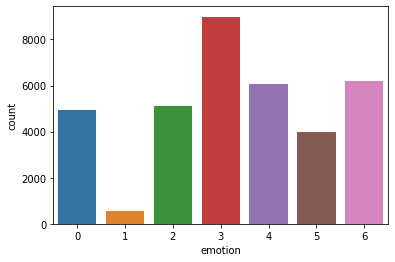

In [ ]:
print(df.emotion.value_counts())
sns.countplot(df.emotion)
pyplot.show()

So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral and we are also intersted in these three classes only.

# Data Preparation

In [ ]:
# check the pixel range
math.sqrt(len(df.pixels[0].split(' ')))

48.0

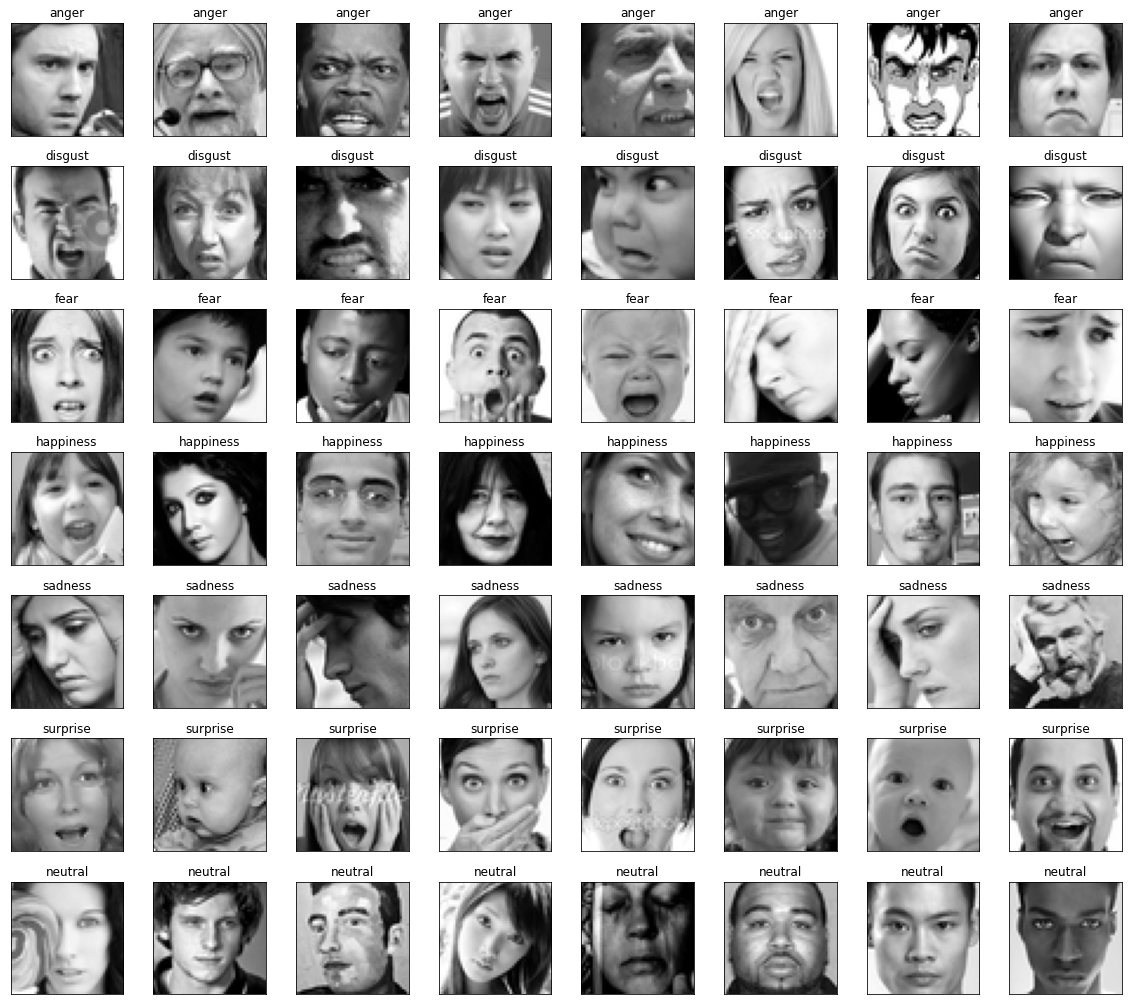

In [ ]:
fig = pyplot.figure(1, (16, 16))
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(8):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(8, 8, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

## Select Majority Emotions and Group them into Happy and Not Happy
0 - Anger
3 - Happiness
4 - Sadness

In [ ]:
INTERESTED_LABELS = [0, 3, 4]

In [ ]:
dfnew = df[df.emotion.isin(INTERESTED_LABELS)]
print(f"The original dataset shape is {df.shape}")
print(f"The new dataset shape is {dfnew.shape}")

The original dataset shape is (35887, 3)
The new dataset shape is (20019, 3)


0    11030
1     8989
Name: emotion, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


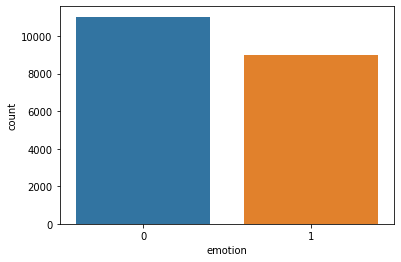

In [ ]:
# change label Not Happy 0 = 0 + 4; Happy 1 = 3
dfnew = dfnew.replace({'emotion': {0: 0, 4: 0, 3: 1}})

print(dfnew.emotion.value_counts())
sns.countplot(dfnew.emotion)
pyplot.show()

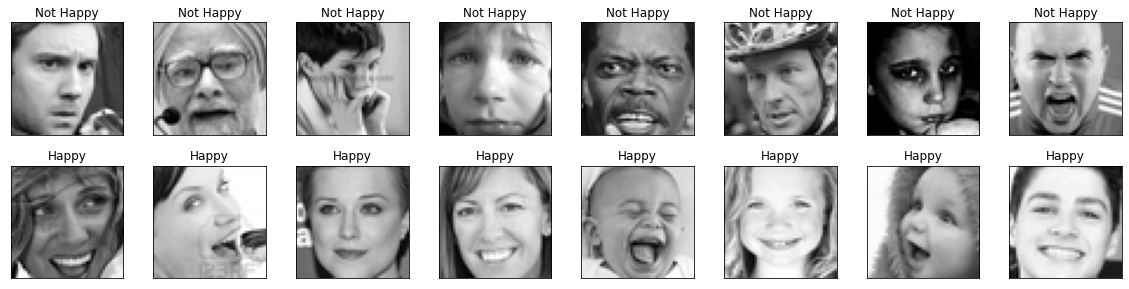

In [ ]:
fig = pyplot.figure(1, (16, 16))
emotion_label_to_text_new = {0:'Not Happy', 1:'Happy'}

#random_Happy_imgs = np.random.choice(np.where(dfnew[:, 1]==1)[0], size=8)
#random_Nothappy_imgs = np.random.choice(np.where(dfnew[:, 0]==1)[0], size=8)


k = 0
for label in sorted(dfnew.emotion.unique()):
    for j in range(8):
        px = dfnew[dfnew.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(8, 8, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text_new[label])
        pyplot.tight_layout()

## Convert data into Neural Network compatible format

In [ ]:
img_array = dfnew.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(20019, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(dfnew.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(20019, 2)

??????below code????

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1}


## `Splitting the data into training and validation set.`

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((18017, 48, 48, 1), (2002, 48, 48, 1), (18017, 2), (2002, 2))

# Modeling

https://keras.io/api/models/model_training_apis/


In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 14
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<ipython-input-27-cae8b5eda1b9>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/14
563/563 [==============================] - 1345s 2s/step - loss: 0.8379 - accuracy: 0.5687 - val_loss: 0.6086 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 2/14
563/563 [==============================] - 1363s 2s/step - loss: 0.6300 - accuracy: 0.6496 - val_loss: 0.5491 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 3/14
563/563 [==============================] - 1361s 2s/step - loss: 0.5308 - accuracy: 0.7329 - val_loss: 0.4568 - val_accuracy: 0.7947 - lr: 0.0010
Epoch 4/14
563/563 [==============================] - 1366s 2s/step - loss: 0.4479 - accuracy: 0.7903 - val_loss: 0.3334 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 5/14
563/563 [==============================] - 1390s 2s/step - loss: 0.3947 - accuracy: 0.8251 - val_loss: 0.3267 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 6/14
563/563 [==============================] - 1385s 2s/step - loss: 0.3657 - accuracy: 0.8408 - val_loss: 0.3609 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 7/14
563/563 [==============================] - 1385

verbose: https://stackoverflow.com/questions/47902295/what-is-the-use-of-verbose-in-keras-while-validating-the-model

In [ ]:
# evaluate the model
X = X_train
Y = y_train

scores = model.evaluate(X, Y, verbose=1)
print("Training Set Stats:")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print("--------------------")

X1 = X_valid
Y1 = y_valid
scores1 = model.evaluate(X1, Y1, verbose=1)
print("Testing Set Stats:")
print("%s: %.2f%%" % (model.metrics_names[1], scores1[1]*100))

564/564 [==============================] - 328s 581ms/step - loss: 0.2004 - accuracy: 0.9258
Training Set Stats:
accuracy: 92.58%
--------------------
63/63 [==============================] - 36s 569ms/step - loss: 0.2146 - accuracy: 0.9191
Testing Set Stats:
accuracy: 91.91%


## Save the model

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [ ]:
# import os
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/MPMD3.4 AI Balloons Happy Face/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5, what's the difference between the two models???
model.save_weights("/content/drive/MyDrive/Colab Notebooks/MPMD3.4 AI Balloons Happy Face/model_weights.h5")    
model.save("/content/drive/MyDrive/Colab Notebooks/MPMD3.4 AI Balloons Happy Face/model.h5")
print("Saved model to disk")

Saved model to disk


# Model Metrics

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

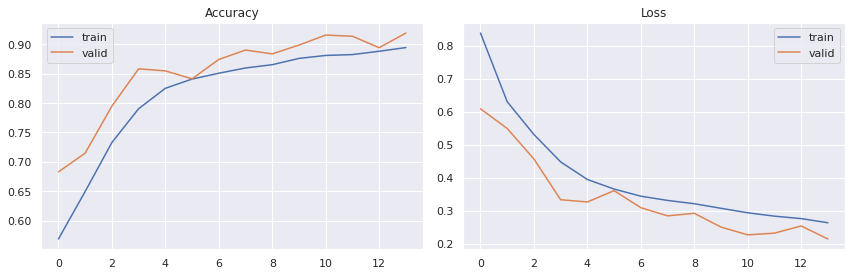

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

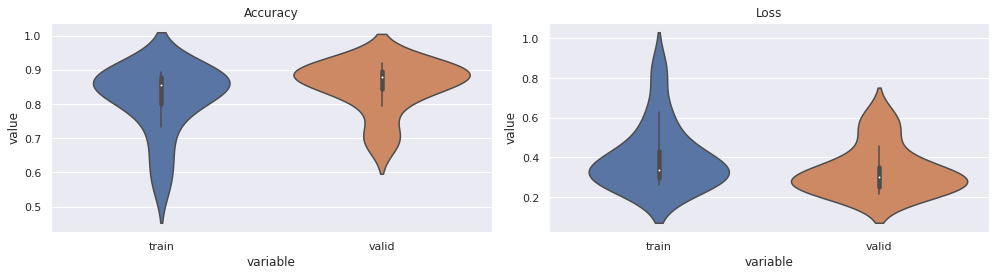

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

63/63 [==============================] - 36s 573ms/step
total wrong validation predictions: 162


              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1103
           1       0.92      0.90      0.91       899

    accuracy                           0.92      2002
   macro avg       0.92      0.92      0.92      2002
weighted avg       0.92      0.92      0.92      2002



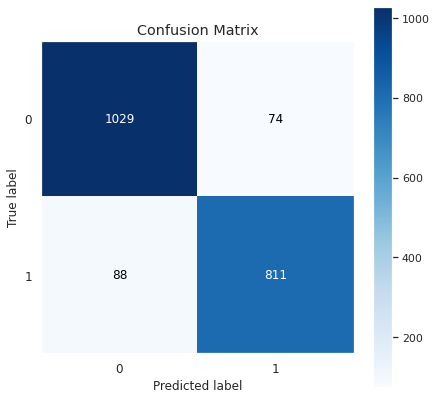

In [ ]:
yhat_valid = np.argmax(model.predict(X_valid), axis=-1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing an excellent job on both classes. But for happy, the false negative is higher and overall F1 score is slightly lower than Not Happy.
One of the reason for this could be the fact that calss Happy has less data.

# Final Examination

In [ ]:
mapper = {
    0: "Not",
    1: "Happy"
}

1/1 [==============================] - 0s 43ms/step


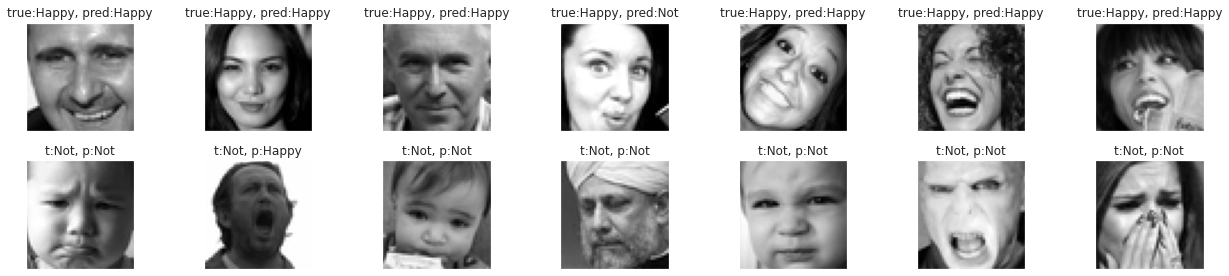

In [ ]:
np.random.seed(2)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=7)
random_nothappy_imgs = np.random.choice(np.where(y_valid[:, 1]==0)[0], size=7)

fig = pyplot.figure(1, (18, 4))

for i, (happyidx, nothappyidx) in enumerate(zip(random_happy_imgs, random_nothappy_imgs)):
        ax = pyplot.subplot(2, 7, i+1)
        sample_img = X_valid[happyidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:Happy, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=-1)[0]]}")

        ax = pyplot.subplot(2, 7, i+8)
        sample_img = X_valid[nothappyidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Not, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=-1)[0]]}")

        pyplot.tight_layout()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.

1/1 [==============================] - 0s 43ms/step


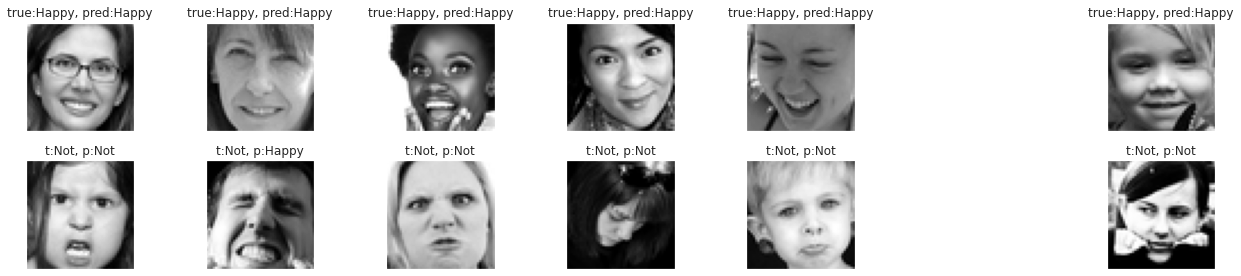

In [ ]:
np.random.seed(3)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=7)
random_nothappy_imgs = np.random.choice(np.where(y_valid[:, 1]==0)[0], size=7)

fig = pyplot.figure(1, (18, 4))

for i, (happyidx, nothappyidx) in enumerate(zip(random_happy_imgs, random_nothappy_imgs)):
        ax = pyplot.subplot(2, 7, i+1)
        sample_img = X_valid[happyidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:Happy, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=-1)[0]]}")

        ax = pyplot.subplot(2, 7, i+8)
        sample_img = X_valid[nothappyidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Not, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=-1)[0]]}")

        pyplot.tight_layout()

1/1 [==============================] - 0s 40ms/step


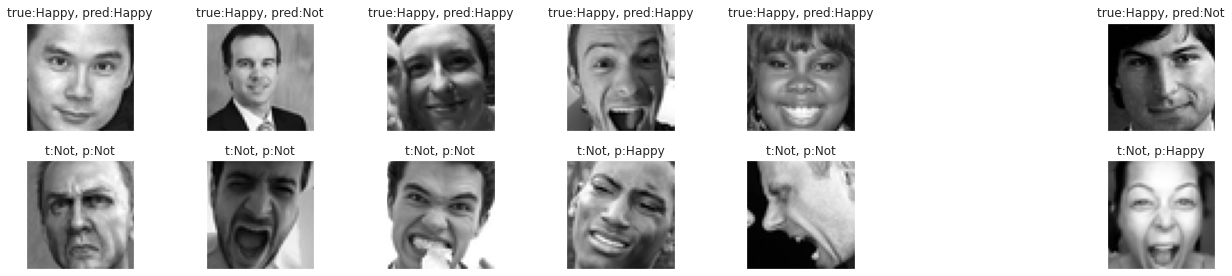

In [ ]:
np.random.seed(4)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=7)
random_nothappy_imgs = np.random.choice(np.where(y_valid[:, 1]==0)[0], size=7)

fig = pyplot.figure(1, (18, 4))

for i, (happyidx, nothappyidx) in enumerate(zip(random_happy_imgs, random_nothappy_imgs)):
        ax = pyplot.subplot(2, 7, i+1)
        sample_img = X_valid[happyidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:Happy, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=-1)[0]]}")

        ax = pyplot.subplot(2, 7, i+8)
        sample_img = X_valid[nothappyidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Not, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=-1)[0]]}")

        pyplot.tight_layout()